
# Description 

Lending Club is a platfform which allows borrowers to ask for loans, and investors to fund them. The borwers have to return the loan with interest rates. Borrowers with high credit scores will get low interset rates and the opposite. The higher the risk the highr the ROI.     
The data set includes information about funded loans from Lending Club platfform; It includes information about the loans, the borrowers and what are the loans status. 

# Goal
Our goal is to help investors decide if they should fund a specific loan or not.
We should note that good loan and bad loan can be interpreted in different ways. 
I will introduce the different approaches and select one of them. 

In [1]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sl
import seaborn as sns
from itertools import combinations
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

# Basic data analysis
In this section i will explore the data, define target value, handle with missing values, handle with categorial featuers and find correlation between features.

In [2]:
df = pd.read_csv('loan.csv',low_memory=False)

## Target value

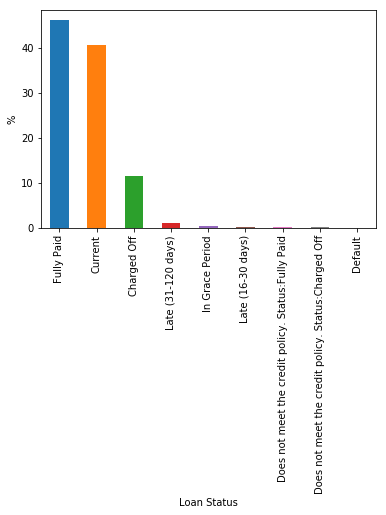

In [3]:
pl = df['loan_status'].value_counts(normalize=True).mul(100).plot(kind='bar')
ay = pl.set_ylabel("%")
ax = pl.set_xlabel("Loan Status")

Loan status could be:
1. Fully paid: the borrower paid all payments in time and the loan has finished. This status will be categorized as good loan. 
2. Current: The loan period has not finished yet. So far, all payments are in time. This can be interpreted as good loan, however it is not sure if the borrower will pay all future payments, so it is also possible not to use loans in this status. I will consider all loans with Current status as good loans. 
3. Charged off / Default: The borrower has not repaid the loan. This status will be categorized as bad loan.
4. Late (16-30) / In Grace period / Late (31 - 120): This can be interpreted in different ways; it depends on the investor's goals. Does the investor need the money every month? or does he invest for long term? For each interpretation we can design new models. I will consider this section as bad loans.    
5. Does not meet the credit policy - Charged off: The borrower has not repaid the loan. This status will be categorized as bad loan.
6. Does not meet the credit policy - Fully paid. Regardless the credit policy - the borrower has fully paid his loan. It will be categorized as good loan. 

In [4]:
good_loan = ["Current", "Fully Paid" , 'Does not meet the credit policy. Status:Fully Paid']
df['loan_label'] = np.nan

def loan_label(status):
    if status in good_loan:
        return 1
    else:
        return 0
    
df['loan_label'] = df['loan_status'].apply(loan_label)
df.drop(['loan_status'],axis=1, inplace=True)


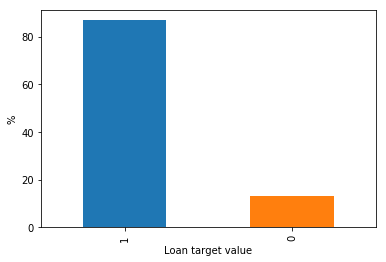

In [5]:
pl = df['loan_label'].value_counts(normalize=True).mul(100).plot(kind='bar')
ay = pl.set_ylabel("%")
ax = pl.set_xlabel("Loan target value")


## Feature exploration , Data cleaning  and handling missing values.
In this section I explore some of the features that seems to be high correlated with the target value. 
I remove not relevant features like member id etc, and I handle missing values. 


In [6]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,loan_label
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,1
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,1
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,1
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,1
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,1


In [7]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Data columns (total 145 columns):
id                                            float64
member_id                                     float64
loan_amnt                                     int64
funded_amnt                                   int64
funded_amnt_inv                               float64
term                                          object
int_rate                                      float64
installment                                   float64
grade                                         object
sub_grade                                     object
emp_title                                     object
emp_length                                    object
home_ownership                                object
annual_inc                                    float64
verification_status                           object
issue_d                                       object
pymnt_plan                        

### Missing values

In this section i handle missing values.

For every missing value of a continuous feature I assign the mean value.

For every missing value of a categorial feature I assign the empty string.

Future work:
Explore every feature individually, analyze what value should be assigned instead of the missing values. 


In [8]:
#Missing values check
nan_mean = df.isna().mean()
nan_mean = nan_mean[nan_mean > 0].sort_values()
nan_mean

zip_code                                      4.423471e-07
annual_inc                                    1.769389e-06
delinq_amnt                                   1.282807e-05
pub_rec                                       1.282807e-05
acc_now_delinq                                1.282807e-05
open_acc                                      1.282807e-05
total_acc                                     1.282807e-05
delinq_2yrs                                   1.282807e-05
earliest_cr_line                              1.282807e-05
inq_last_6mths                                1.327041e-05
last_credit_pull_d                            3.229134e-05
tax_liens                                     4.644645e-05
collections_12_mths_ex_med                    6.414033e-05
chargeoff_within_12_mths                      6.414033e-05
pub_rec_bankruptcies                          6.038038e-04
dti                                           7.568559e-04
revol_util                                    7.971095e-

id, member_id , url have no values at all. They are not necessary. 

In [9]:
df.drop(['id','member_id','url'],axis=1, inplace=True)

In [10]:
#For every float64 trypes i will set the empty values as the mean value.
float64_cols = df.select_dtypes(include=[np.float64]).columns
df[float64_cols] = df[float64_cols].fillna(df[float64_cols].mean())
#For the categorial type i will set the empty values to empty string. 
categorial_cols = df.select_dtypes(include=[object]).columns
df[categorial_cols] = df[categorial_cols].fillna(' ')

nan_mean = df.isna().mean()
nan_mean = nan_mean[nan_mean > 0].sort_values()
nan_mean

Series([], dtype: float64)

### Feature exploration

The purpose of this section is to understand the data.
I explore the following features: loan_amnt , term , grade , sub_grade, annual_inc , addr_state. 
According to my perspective these feature should be high correlated to the target. 
annual_inc, loan_amnt and term are the basic parameters for a loan. A necessary parameter for a loan is that the borrower earns more than the amount he/she should return every month.
grade and sub grade are corelated to the interest rate, which can influence the chances of repay the loan. addr_state migh have correlation to the target (states with more work opportunities, different social-economic status etc). 
Moreover, I check correlation according to Pearson's correlation coefficient. 
Future work: Explore more features, finding more correlations and extracting new features.


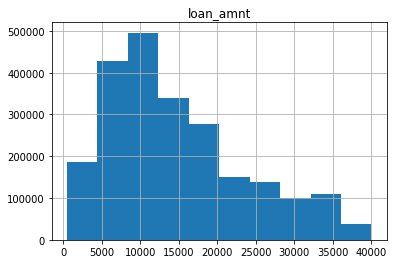

In [11]:
hist1 = df.hist('loan_amnt')

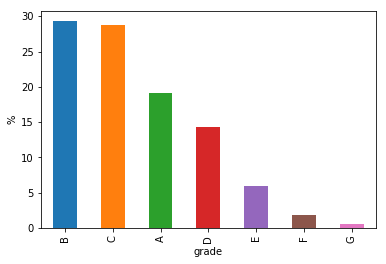

In [12]:
pl = df['grade'].value_counts(normalize=True).mul(100).plot(kind='bar')
ay = pl.set_ylabel("%")
ax = pl.set_xlabel("grade")

<Figure size 432x288 with 0 Axes>

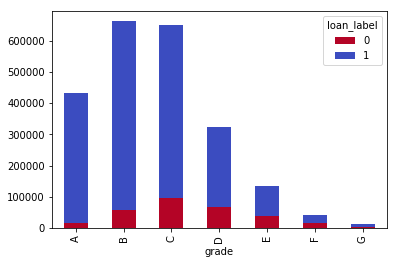

In [13]:
plt.figure(figsize = (6,4))
loans_by_grade = df.groupby(['grade', 'loan_label']).size()
loans_by_grade.unstack().plot(kind='bar', stacked=True, colormap=plt.cm.coolwarm_r, grid=False)
plt.show()

In grades E,F,G - bad loans are more frequent then grades A,B,C,D

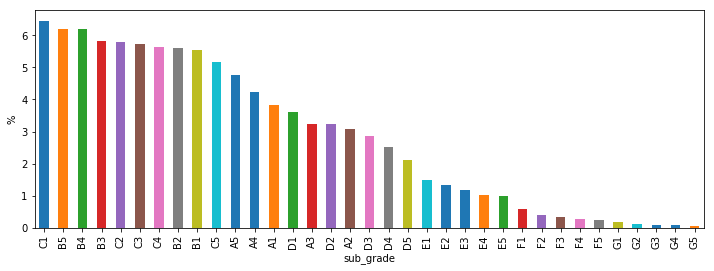

In [14]:
pl = df['sub_grade'].value_counts(normalize=True).mul(100).plot(kind='bar',figsize=(12,4))
ay = pl.set_ylabel("%")
ax = pl.set_xlabel("sub_grade")

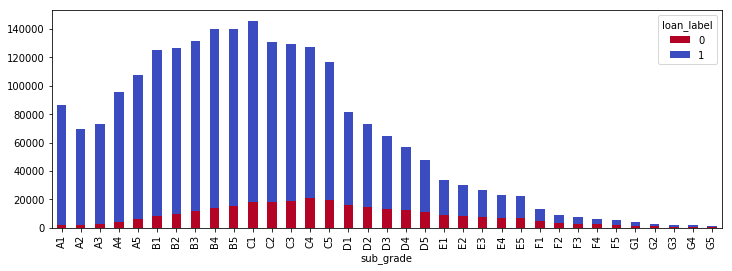

In [15]:
loans_by_grade = df.groupby(['sub_grade', 'loan_label']).size()
loans_by_grade.unstack().plot(kind='bar', stacked=True, colormap=plt.cm.coolwarm_r, grid=False , figsize=(12,4))
plt.show()

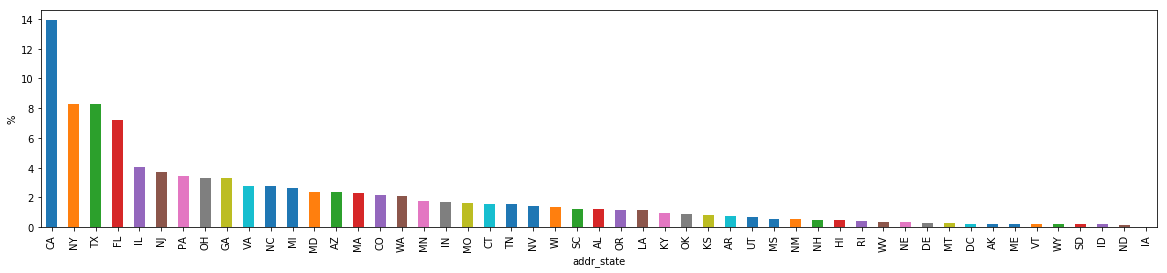

In [16]:
pl = df['addr_state'].value_counts(normalize=True).mul(100).plot(kind='bar' , figsize=(20,4))
ay = pl.set_ylabel("%")
ax = pl.set_xlabel("addr_state")

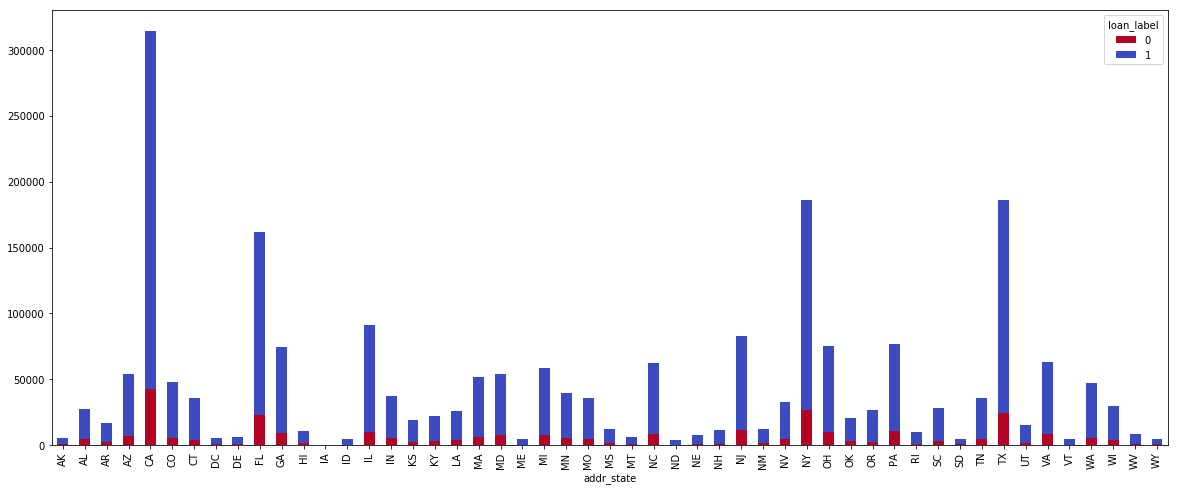

In [17]:
loans_by_grade = df.groupby(['addr_state', 'loan_label']).size()
loans_by_grade.unstack().plot(kind='bar', stacked=True, colormap=plt.cm.coolwarm_r, grid=False , figsize=(20,8))
plt.show()




We can see that loans in some states are more common than in others. 
It is intersting to explore why. Maybe it is the amount of people living in a state, or maybe higher social-economic status allows people to take more loans.
However, we can not understand from the graph above where is the safest place to fund a loan from.

### Correlation between features
Finding correlation between features using Pearson's correlation coefficient.
Features with high correlation might not be needed and might reduce the efficiency of some models (random forest, GBM).
In this point I will leave them as they are. 
If the estimator’s results will not be good enough I will consider going back to this point and remove some of the features.

In [18]:
features = df.select_dtypes('number').columns.values
comb_features = np.array(list(combinations(features, 2)))
corr_features = np.array([])
for comb in comb_features:
    corr = pearsonr(df[comb[0]], df[comb[1]])[0]
    corr_features = np.append(corr_features, corr)

In [19]:
high_corr_num = comb_features[np.abs(corr_features) >= 0.9]
high_corr_num

array([['loan_amnt', 'funded_amnt'],
       ['loan_amnt', 'funded_amnt_inv'],
       ['loan_amnt', 'installment'],
       ['funded_amnt', 'funded_amnt_inv'],
       ['funded_amnt', 'installment'],
       ['funded_amnt_inv', 'installment'],
       ['open_acc', 'num_sats'],
       ['out_prncp', 'out_prncp_inv'],
       ['total_pymnt', 'total_pymnt_inv'],
       ['total_pymnt', 'total_rec_prncp'],
       ['total_pymnt_inv', 'total_rec_prncp'],
       ['recoveries', 'collection_recovery_fee'],
       ['tot_cur_bal', 'tot_hi_cred_lim'],
       ['num_actv_rev_tl', 'num_rev_tl_bal_gt_0']], dtype='<U42')

### Categorial features

In this section I explore and handle categorial features. 

In [20]:
#Check if there are categorially features that has relativity large number of values: 
cat_feat = df.select_dtypes('object').columns.values
df[cat_feat].nunique().sort_values()

term                              2
application_type                  2
initial_list_status               2
hardship_flag                     2
disbursement_method               2
pymnt_plan                        2
debt_settlement_flag              2
hardship_type                     2
verification_status               3
settlement_status                 4
hardship_status                   4
verification_status_joint         4
home_ownership                    6
hardship_loan_status              6
grade                             7
hardship_reason                  10
emp_length                       12
purpose                          14
payment_plan_start_date          27
hardship_start_date              27
hardship_end_date                28
sub_grade                        35
addr_state                       51
debt_settlement_flag_date        83
settlement_date                  90
next_pymnt_d                    106
last_pymnt_d                    136
issue_d                     

I remove emp_title and title - there are too many different types of categories - which can cause the model to overfit.

In [21]:
df.drop(['emp_title','title'],axis=1, inplace=True)

I remove loan description - there are too many differnt types of categories - which can cause the model to overfitt.

Future work: reduce number of differnt categories in this feature by changing the categories into more "wider" categories. 
For example - combine all student loans into one category etc.

another option: use embedding(word2vec) in oreder to represent a categorial feature using a vector.



In [22]:
df.drop(['desc'],axis=1, inplace=True)

Lets look at the following features with big amout of differnt values: earliest_cr_line, last_credit_pull_d , issue_d , last_pymnt_d

In [23]:
df[['earliest_cr_line' ,'last_credit_pull_d','issue_d','last_pymnt_d']].head()

,earliest_cr_line,last_credit_pull_d,issue_d,last_pymnt_d
0,Apr-2001,Feb-2019,Dec-2018,Feb-2019
1,Jun-1987,Feb-2019,Dec-2018,Feb-2019
2,Apr-2011,Feb-2019,Dec-2018,Feb-2019
3,Feb-2006,Feb-2019,Dec-2018,Feb-2019
4,Dec-2000,Feb-2019,Dec-2018,Feb-2019


I can see that all of them are dates. I can extract new features out of them. For example: issue_d - last_credit_pull_d. and the new feature will be continuous.
There are alot of hypothesis regarding this data. For this step, I will leave it as is.
 

### Removing not relevant features

A deep look into the data will show that there are features that will not be visible to an investor at the "funding" phase.

The features are:
total_rec_prncp:  how much money has received till now. When an investor thinks if he should fund a load or not, this parameter will not be available. This could cause the estimators to get very good results, but they will be not realistic; if the borrower repaid 90% of the loan, most of the chances he/she will fully repay the loan. This feature should be removed. 

The same goes for: last_pymnt_amnt , total_pymnt ,total_rec_int ,funded_amnt, funded_amnt_inv ,last_pymnt_d.

In this section I drop all of these features.


In [24]:
df.drop(["total_rec_prncp","last_pymnt_amnt","total_pymnt","total_rec_int","total_pymnt_inv","funded_amnt","funded_amnt_inv","last_pymnt_d"],axis=1, inplace=True)

# Data encoding and preprocessing

In this section i prepare the data for the traing phase.

## Code categorial features

Turning strings into integers

In [25]:
categorical_features_list = df.select_dtypes('object').columns
categorical_features_list_indices = [df.columns.get_loc(c) for c in categorical_features_list]
print(categorical_features_list , categorical_features_list_indices)

Index(['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'issue_d', 'pymnt_plan', 'purpose', 'zip_code',
       'addr_state', 'earliest_cr_line', 'initial_list_status', 'next_pymnt_d',
       'last_credit_pull_d', 'application_type', 'verification_status_joint',
       'sec_app_earliest_cr_line', 'hardship_flag', 'hardship_type',
       'hardship_reason', 'hardship_status', 'hardship_start_date',
       'hardship_end_date', 'payment_plan_start_date', 'hardship_loan_status',
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date'],
      dtype='object') [1, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 17, 26, 32, 33, 37, 40, 97, 107, 108, 109, 110, 113, 114, 115, 118, 122, 123, 124, 125, 126]


In [26]:
for cat in categorical_features_list:
     df[cat] = pd.Categorical(df[cat]).codes

## Train data and test data. 

Preparing Train Data and test data.
I randomly divide the data into test and train data. 
The data is shuffled. 

Note: I examine few models. I normalize and encode categorial features for each model separately.

Future work: Try to divide the data according to dates and not randomly, i.e train data will be older than test data. This could cause the model to be more efficient.

In [27]:
y = df['loan_label'].copy()
X = df.drop(['loan_label'], axis=1, errors='ignore').copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0 , test_size =0.2 , shuffle= True)


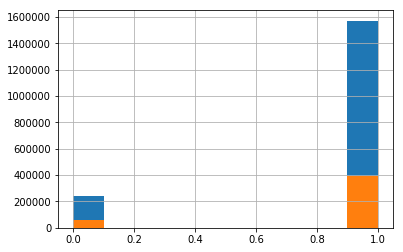

In [28]:
y_train.hist()
y_test.hist()

Test data and train data seems to have similar ratio between good loans and bad loans.

# Estimators

I train several models and examine their results. 
1. Naive estimator. Always predict 1 (always take the loan). This is the "base" estimator, all other estimator results will be compared to this one. This can help evaluate the estimator’s results. 
2. GBM
3. Logistic regression
4. NN

I choose to use these estimators because they are suitable for binary classification problems.

Evaluation parameters for this data set:

TP: predicted not to take the loan and it was a bad loan.

TN: predicted to the take the loan and it was a good loan.

Accuracy: does not say a lot because the data is not balanced. Most of the loans are good loans, and the model predicted them. This is not the interesting case. 

Precision: loans that the estimator predicted not to take them, but they were good loans. Indicates low risk estimator.

Recall: bad loans that were predicted as good. This is a dangerous case because the investors can loose money.





In [29]:
# Function for printing estimator results
from sklearn.metrics import confusion_matrix
def print_model_results(y,y_pred):
    cm = confusion_matrix(y, y_pred)
    tp = cm[0,0]
    tn = cm[1,1]
    fn = cm[0,1]
    fp = cm[1,0]
    acc = (tp + tn) / (tp + tn + fn + fp)
    print ("Accuracy:", acc )
    if ((tp + fp) != 0):
        prec = tp / (tp + fp)
        print ("Precision:", prec )
    else:
        print ("Precision:", '0' )
    if ((tp + fn) != 0):
        recall = tp / (tp + fn)
        print ("Recall:", recall )
    else:
        print ("Recall:", '0' )
    

## Naive estimator

In [30]:
predictions = np.ones(shape=(np.shape(y_test)))
cm = confusion_matrix(y_test,predictions )
cm    

array([[     0,  59407],
       [     0, 392727]], dtype=int64)

In [31]:
print_model_results(y_test,predictions)

Accuracy: 0.8686075367037206
Precision: 0
Recall: 0.0


## GBM

There is no need to normlize the data and encode categorial features for this estimator. 
Note that the hyper parameters are defualt parameters.
Future work will be to optimize hyper parameters.

In [32]:
import lightgbm

In [33]:
parameters = {
    'metric': 'auc',
    'is_unbalance': 'true',
    'num_leaves': 70,
    'learning_rate': 0.01
}

train_data = lightgbm.Dataset(X_train, label=y_train, categorical_feature=categorical_features_list_indices)
test_data = lightgbm.Dataset(X_test, label=y_test , categorical_feature=categorical_features_list_indices)

model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=100,
                       early_stopping_rounds=10)

[1]	valid_0's auc: 0.918207
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.918245
[3]	valid_0's auc: 0.918233
[4]	valid_0's auc: 0.918358
[5]	valid_0's auc: 0.919018
[6]	valid_0's auc: 0.919258
[7]	valid_0's auc: 0.920217
[8]	valid_0's auc: 0.920589
[9]	valid_0's auc: 0.920899
[10]	valid_0's auc: 0.920993
[11]	valid_0's auc: 0.921064
[12]	valid_0's auc: 0.9211
[13]	valid_0's auc: 0.921129
[14]	valid_0's auc: 0.92123
[15]	valid_0's auc: 0.921271
[16]	valid_0's auc: 0.921704
[17]	valid_0's auc: 0.921829
[18]	valid_0's auc: 0.921873
[19]	valid_0's auc: 0.922197
[20]	valid_0's auc: 0.92227
[21]	valid_0's auc: 0.922394
[22]	valid_0's auc: 0.922381
[23]	valid_0's auc: 0.922438
[24]	valid_0's auc: 0.922544
[25]	valid_0's auc: 0.922614
[26]	valid_0's auc: 0.922669
[27]	valid_0's auc: 0.922726
[28]	valid_0's auc: 0.92274
[29]	valid_0's auc: 0.922752
[30]	valid_0's auc: 0.922766
[31]	valid_0's auc: 0.922815
[32]	valid_0's auc: 0.922829
[33]	valid_0's auc: 0.92

In [34]:
predictions = model.predict(X_test)
cm = confusion_matrix(y_test,np.around(predictions))
cm    

array([[ 37832,  21575],
       [   236, 392491]], dtype=int64)

In [35]:
print_model_results(y_test,np.around(predictions))


Accuracy: 0.9517598764967907
Precision: 0.9938005674056951
Recall: 0.6368273099129732


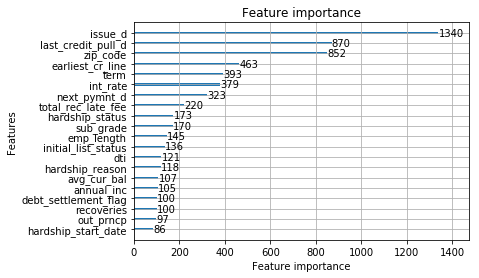

In [36]:
lightgbm.plot_importance(model,max_num_features=20 ,height =0.2)

## Logistic regression

In order to use Logistic regression model i encode the categrial features using one hot encoding, and i normlize the data.

In [37]:
enc = OneHotEncoder(handle_unknown='ignore' , n_values = 'auto',categorical_features = categorical_features_list_indices) 
enc.fit(X_train)
X_train_logistic = enc.transform(X_train)
X_test_logistic = enc.transform(X_test)
print(X_train_logistic.shape)

(1808534, 3262)


Note: one hot encoding cause the matrix to be sparsed.

In [38]:
from sklearn import preprocessing
names = df.columns
continious_features = [x for x in names if x not in categorical_features_list]
scaler = preprocessing.StandardScaler(with_mean=False).fit(X_train_logistic)
X_train_logistic = scaler.transform(X_train_logistic)

scaler = preprocessing.StandardScaler(with_mean=False).fit(X_test_logistic)
X_test_logistic = scaler.transform(X_test_logistic)

print(X_train_logistic.shape)

(1808534, 3262)


In [39]:
from sklearn.linear_model import LogisticRegression

In [40]:
log_reg = LogisticRegression()
log_reg.fit(X_train_logistic, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [41]:
predictions = log_reg.predict(X_test_logistic)
cm = confusion_matrix(y_test, predictions)
cm 

array([[ 35191,  24216],
       [   828, 391899]], dtype=int64)

In [42]:
print_model_results(y_test, predictions)

Accuracy: 0.9446093414784112
Precision: 0.9770121324856326
Recall: 0.5923712693790294


The results are better than the naive estimator. 

## NN

I will use the same train data used for logistic regression (one hot encoding + normalization). 

Future work: instead of using one hot encoding - use embedding layer. 

The parameters i use for the NN are:

2 hidden layers. The sizes are: 400, 100.

Adam optimizer. For now, this is the most efficient optimizer.

Batch size = 50.

Loss function: binary cross-entropy. This is the standard loss function for binary classification.


In [43]:
#NN
from keras.models import Sequential
from keras.layers import Dense

#Set layers size
n_inputs = X_train_logistic.shape[1]
hidden1_amount = 400
hidden2_amount = 100
n_outputs = 1

# define the keras model
model = Sequential()
model.add(Dense(hidden1_amount, input_dim=n_inputs, activation='relu'))
model.add(Dense(hidden2_amount, activation='relu'))
model.add(Dense(n_outputs, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train_logistic, y_train, epochs=10, batch_size=50)
# evaluate the keras model 
_, accuracy = model.evaluate(X_test_logistic, y_test , batch_size = 50)
print('Accuracy: %.2f' % (accuracy*100))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
1808534/1808534 [==============================] - 1063s 588us/step - loss: 0.1885 - acc: 0.9421
Epoch 2/10
1808534/1808534 [==============================] - 1058s 585us/step - loss: 0.1733 - acc: 0.9470
Epoch 3/10
1808534/1808534 [==============================] - 948s 524us/step - loss: 0.1698 - acc: 0.9481
Epoch 4/10
1808534/1808534 [==============================] - 982s 543us/step - loss: 0.1679 - acc: 0.9487
Epoch 5/10
1808534/1808534 [==============================] - 981s 542us/step - loss: 0.1664 - acc: 0.9491s - 
Epoch 6/10
1808534/1808534 [==============================] - 942s 521us/step - loss: 0.1650 - acc: 0.9494
Epoch 7/10
1808534/1808534 [==============================] - 980s 542us/step - loss: 0.1639 - acc: 0.9496
Epoch 8/10
1808534/1808534 [==============================] - 946s 523us/step - loss: 0.1628 - acc: 0.9499
Epoch 9/10
1808534

In [44]:
predictions = model.predict_classes(X_test_logistic)
cm = confusion_matrix(y_test, predictions)
cm 

array([[ 38581,  20826],
       [  2606, 390121]], dtype=int64)

In [45]:
print_model_results(y_test, predictions)

Accuracy: 0.9481746561859979
Precision: 0.9367276082258965
Recall: 0.6494352517380106


# Conclusions

GBM, Logistic regression and NN provides similar results using default parameters. 
NN has the best recall results; GBM hava the best precision and accuracy results.
The results are better than the Naive estimator; however, recall rate can still be improved.
I would expect different results for each estimator, there might be more features that should be removed (section 3.2.5). 

 

# Future work

In order to improve the results future work is needed.
1. Understand the data more deeply.
2. Understand loans buisness more deeply. 
2. Think of new hypothesis and extract new features from the original features. 
3. Complete missing values for each feature indevidually.
4. Remove features that are not needed in order to make the models more efficient and to avoid overfitting. 
5. Optimize the estimator's hyper parameters, understanding the overfitting point.
6. Using different architecture for NN, and use more layers (embedding, word2vec, batch normlization). 
 